# Nature Conservancy Fisheries Kaggle Competition
## Autoencoded fovea for semi-supervised label generation for the purpose of high-resolution image classification 

#### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from scipy import ndimage, misc
import fish_data as fd
import pickle
import tensorflow as tf
import os

In [2]:
help(fd)

Help on module fish_data:

NAME
    fish_data

DESCRIPTION
    fish_data module contains the helper functions for the model build of the
    Nature Conservancy Fisheries Kaggle Competition.
    
    Dependencies:
        * numpy as np
        * os
        * scipy.ndimage as ndimage
        * scipy.misc as misc
        * scipy.special as special
        * matplotlib.pyplot as plt
        * tensorflow as tf
        * pickle

FUNCTIONS
    count_nodes(x, y, kernel, stride, conv_depth, pad='SAME')
        Calculates the number of total nodes present in the next layer of a
        convolution OR max_pooling event.
    
    decode_image(image_name, size, num_channels=3, mean_channel_vals=[155.0, 155.0, 155.0], mutate=False, crop='random', crop_size=224)
        Converts a dequeued image read from filename to a single tensor array,
        with modifications:
            * smallest dimension resized to standard height and width supplied in size param
            * each channel centered to mea

### Partition training images
Each file for training images will be read, dimensions assessed, and appropriate offset values stored into a dictionary.  This dictionary will be used at the time of fovea autoencoding to generate cropped image in real-time.  This way, preloading of a large image set will not be necessary.  

In [3]:
fish_filenames = fd.generate_filenames_list(subdirectory='data/train/', subfolders=True)
print("{} fish filenames collected".format(len(fish_filenames)))

3777 fish filenames collected


#### Test image partition function

In [4]:
test_dict = fd.make_coordinates_dict(filename_list = fish_filenames[0:2], resize_val = 0.75, presize = 224, bins = (4, 4), force = True, store = False)

Attempting to load dictionary pickle...
Not able to load dictionary!
Generating coordinates...


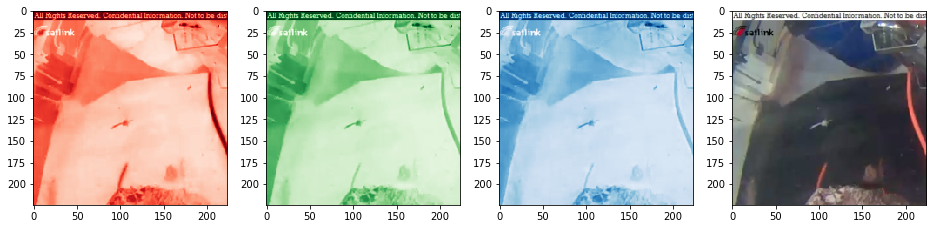

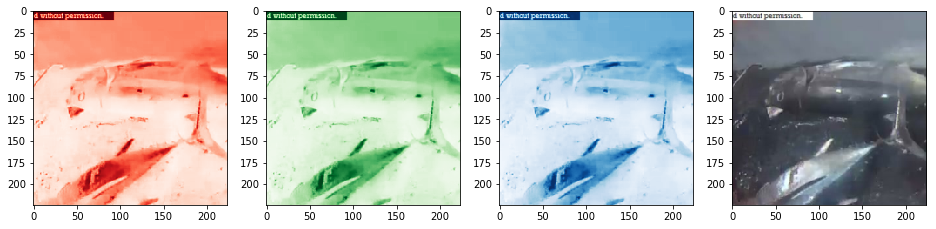

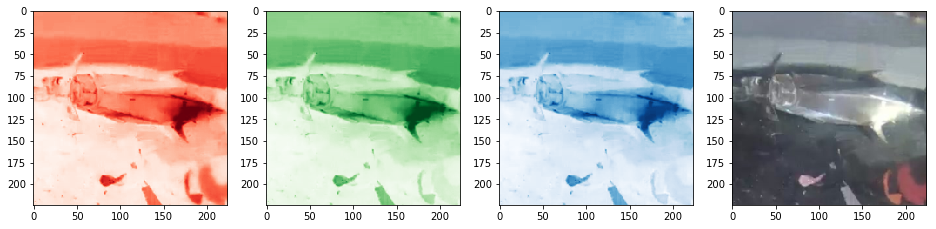

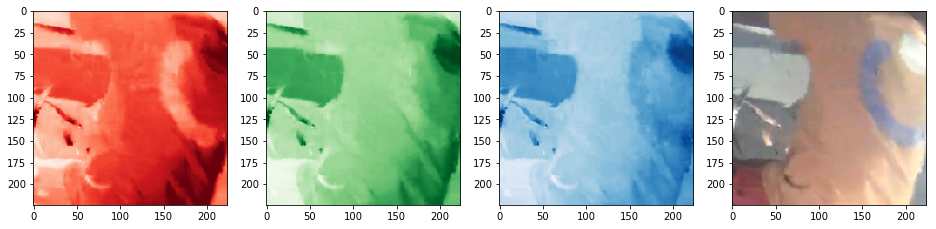

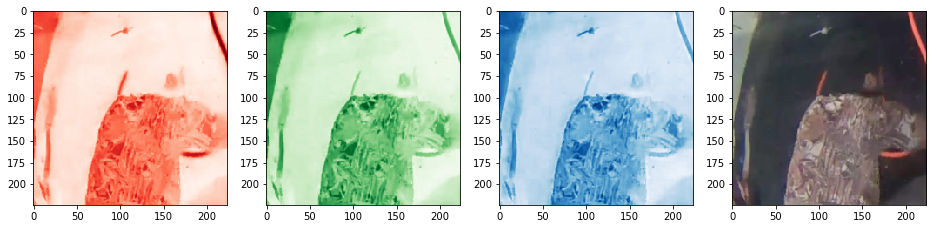

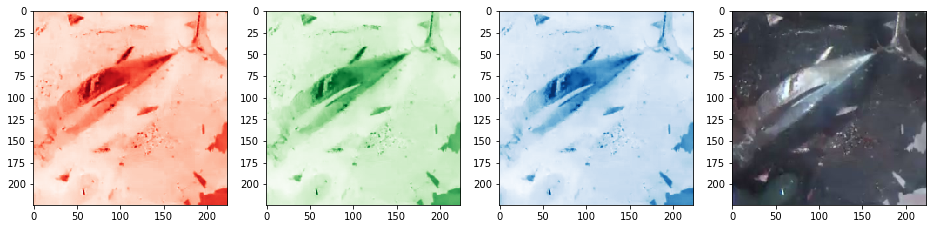

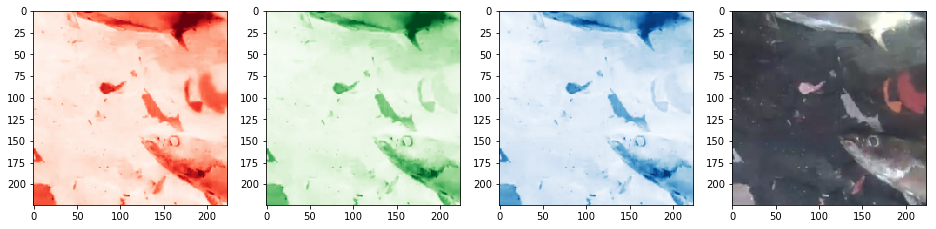

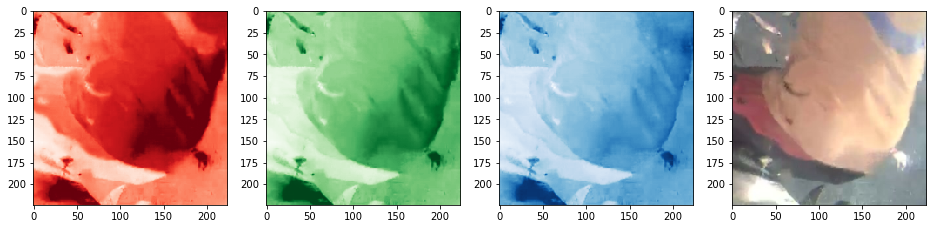

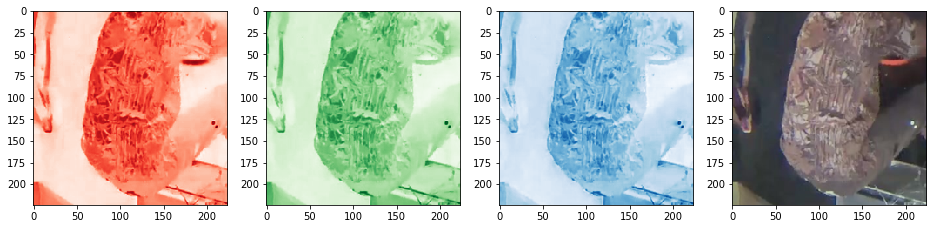

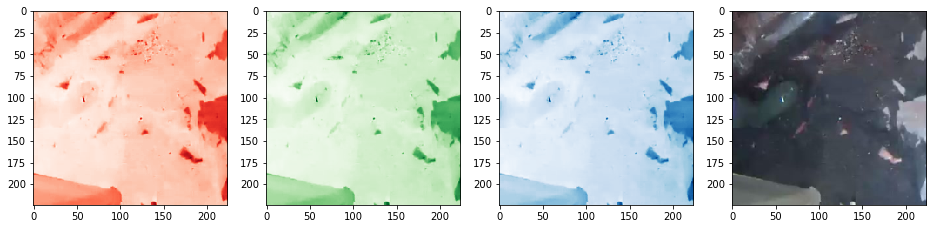

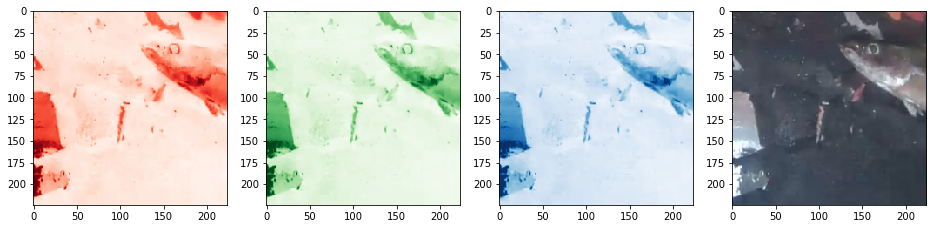

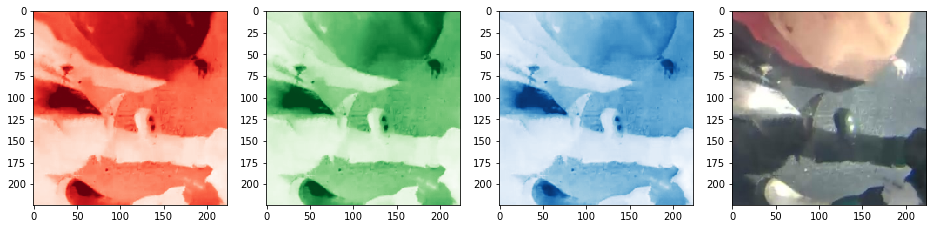

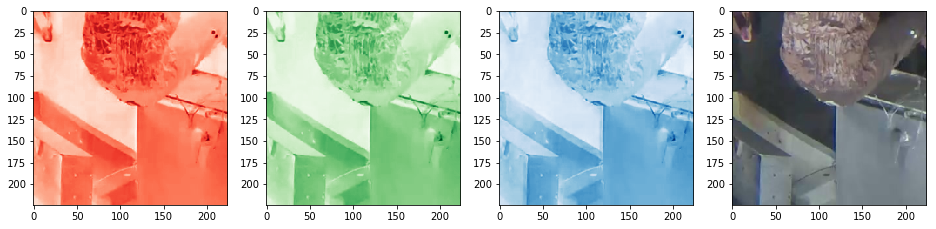

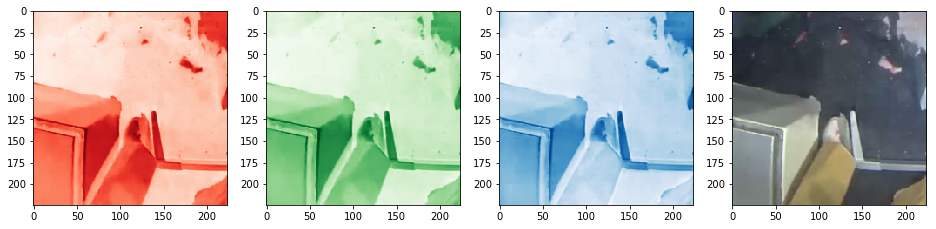

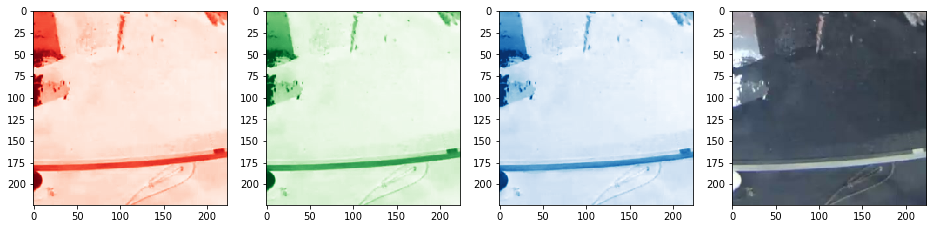

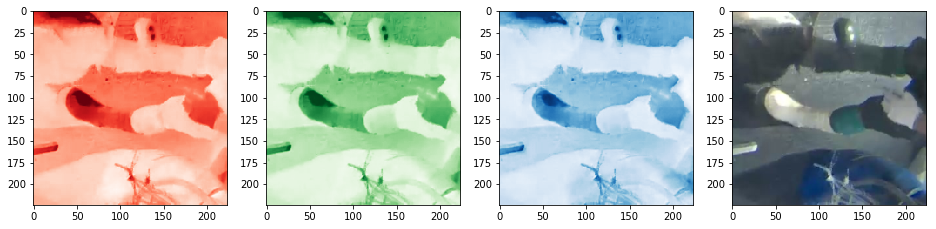

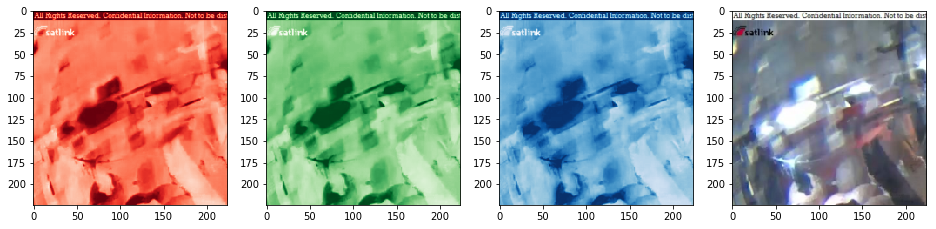

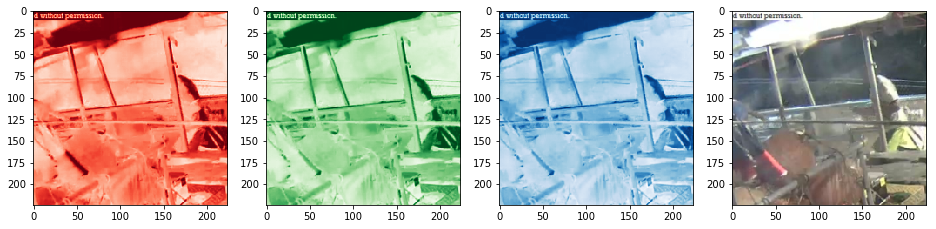

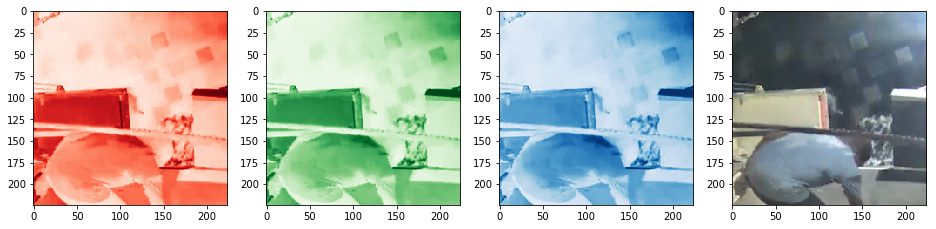

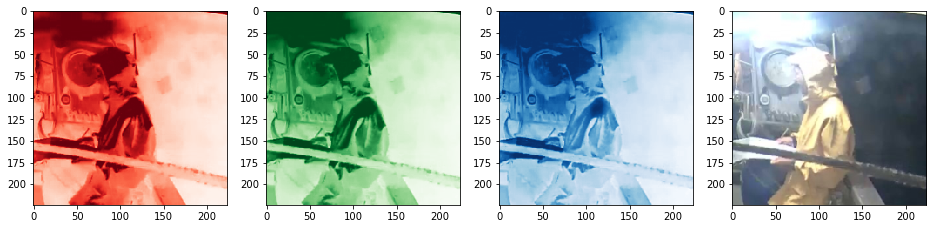

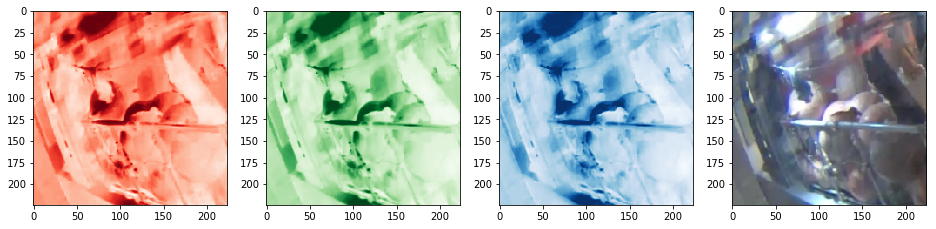

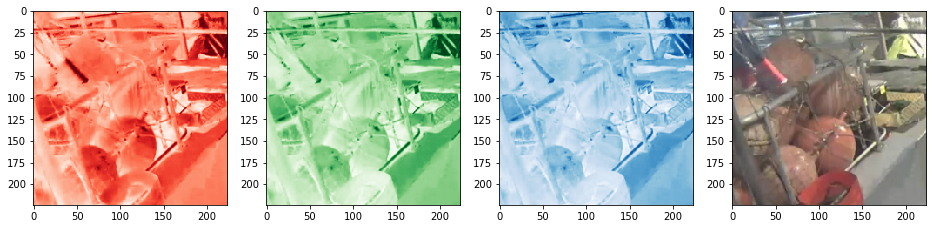

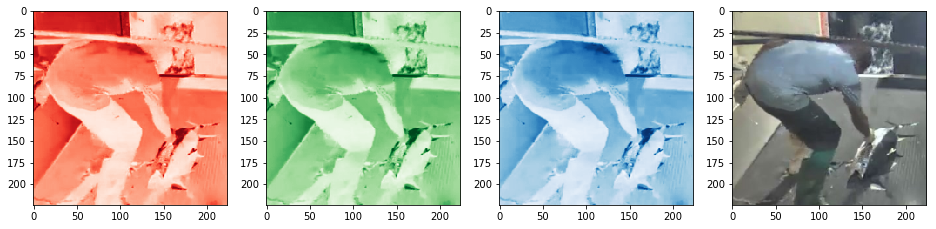

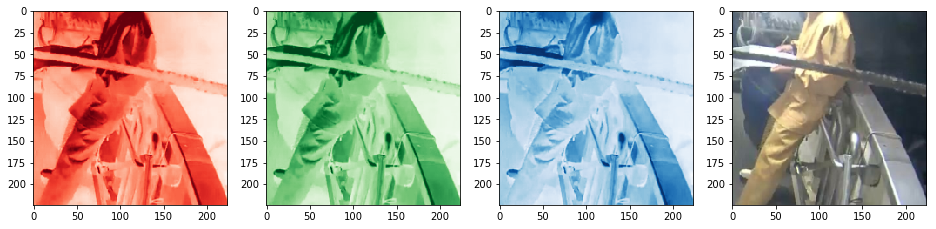

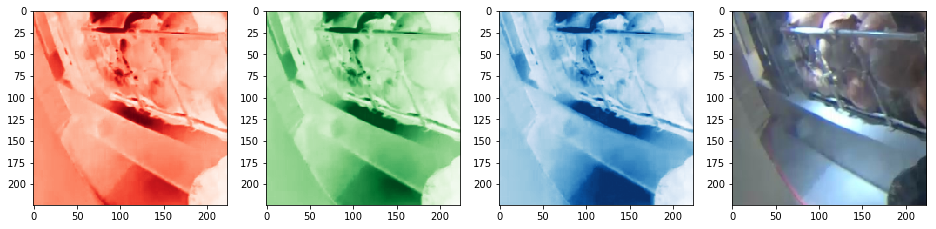

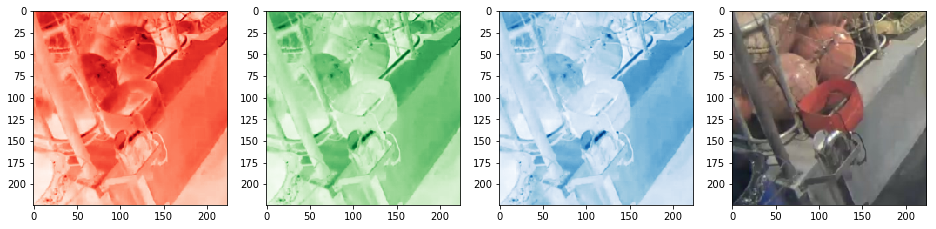

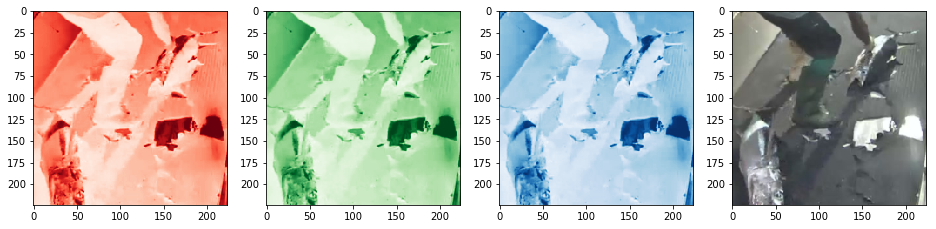

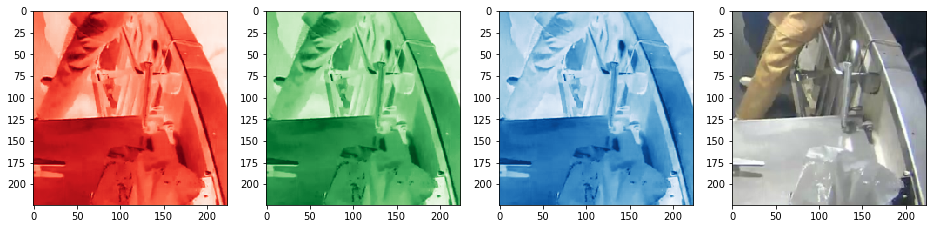

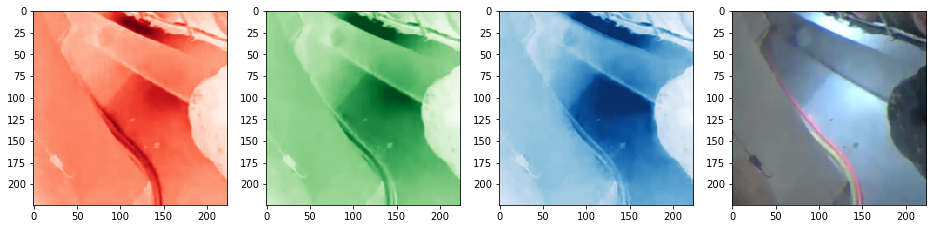

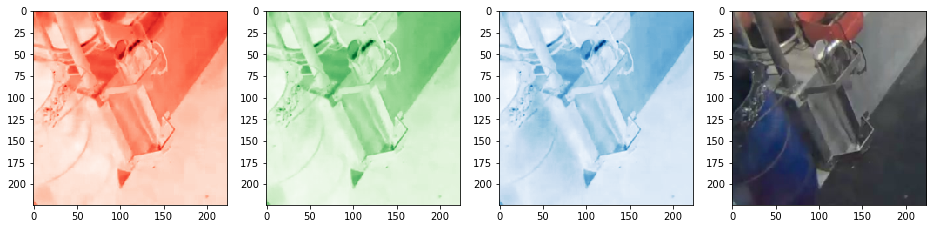

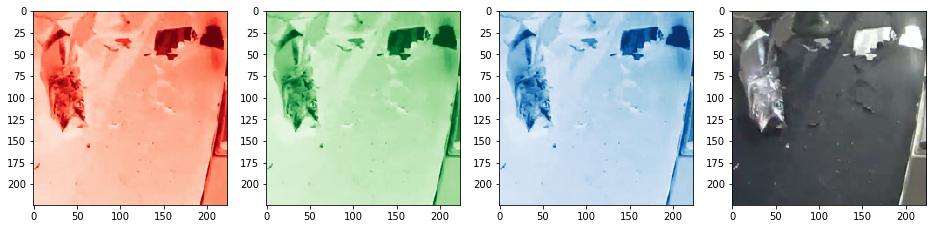

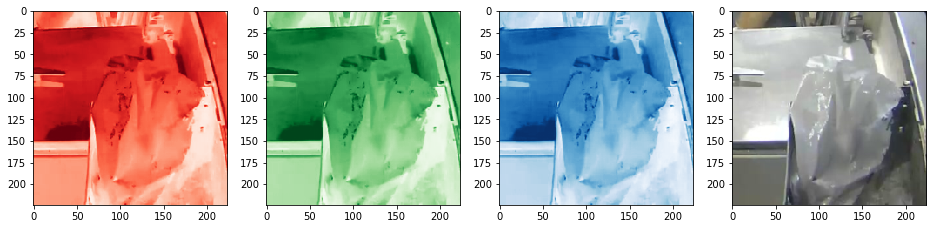

In [5]:
for key in test_dict.keys() :
    kernel, scale = test_dict[key]['parameters']['pixel_dims'], test_dict[key]['parameters']['prescaled']
    img = misc.imresize(misc.imread(key, mode = 'RGB'), size = scale)
    for yx in test_dict.get(key).get('fovea_offsets') :
        fd.show_panel(img[yx[0]:(yx[0]+kernel), yx[1]:(yx[1]+kernel), :])

#### Run make_coordinates to generate coordinate dictionary

In [6]:
master_dict = fd.make_coordinates_dict(filename_list = fish_filenames, 
                                    resize_val = 0.75, presize = 224, bins = (4, 4), force = False, store = True)

Attempting to load dictionary pickle...
Not able to load dictionary!
Generating coordinates...


In [7]:
print("Test for correct number of images in master coordinate dictionary: {}".format(len(master_dict)==len(fish_filenames)))

Test for correct number of images in master coordinate dictionary: True


### Autoencode fovea images
The purpose of this convolutional network will be to generate an **sparse undercomplete autoencoder**.  Forward propigation will 'compress' the image into a smaller number of dimensions ('encoding') prior to a decoding step that attempts to reassemble the original image ('decoding').  The resultant array will be compared to the original with a cost score generated.  Cost will be used for backpropigation through the autoencoder.  

In [ ]:
num_channels = 3
fovea_presize = 384
fovea_size = 224
stddev = 0.5
batch_size = 13*5
fovea_size = 224
learning_rate = 1e-2
beta = 1e-7

In [ ]:
%run -i 'AUTOENCODER_GRAPH.py'

In [ ]:
version_ID = 'v3.3.1.0'
restore_model = False
try :
    del batch_img_foveas
except :
    pass
try :
    del image_foveas
except :
    pass
num_epochs = 30


In [ ]:
len(fish_filenames)

In [ ]:
%run -i 'AUTOENCODER_SESSION.py'

#### Check the autoencoder

In [ ]:
batch_img_foveas = None
image_foveas = None

In [ ]:
with tf.Session(graph = graph) as session_img :
    restorer = tf.train.Saver()
    restorer.restore(session_img, tf.train.latest_checkpoint('FINAL_MODELS'))
    
    epoch_list = fish_filenames.copy()
    for _ in range(5) :
        handle = epoch_list.pop(np.random.randint(0,len(epoch_list),1)[0])
        coordinates = master_dict.get(handle).get('foveas_offsets')
        img = ndimage.imread(handle, mode = 'RGB')
        image_foveas = None
        for yx_coord in coordinates :
            fovea = img[yx_coord[0]:(yx_coord[0]+fovea_presize), yx_coord[1]:yx_coord[1]+fovea_presize, :]
            fovea = misc.imresize(fovea, size = [fovea_size, fovea_size, num_channels])
            try :
                image_foveas = np.concatenate([image_foveas, np.expand_dims(fovea, 0)], 0)
            except :
                image_foveas = np.expand_dims(fovea, 0)
        try :
            batch_img_foveas = np.concatenate([batch_img_foveas, image_foveas], 0)
        except :
            batch_img_foveas = image_foveas
        image_count += 1
    batch_img_foveas =( batch_img_foveas / 255.0) 

    feed_dict = {batch_fovea : batch_img_foveas}
        
    I, O = session_img.run([batch_fovea, decoded], feed_dict = feed_dict)

I = (I ) * 255.0
O = (O ) * 255.0 



In [ ]:
Ic = I[4,:,:,:]
Oc = O[4,:,:,:]

fd.show_panel(Ic)
fd.show_panel(Oc)

### Embed training fovea using the encoder
After sufficient training in the autoencoder, the encoding portion of the network will be used to generate an embedding for every training image.  The embedding table will be an unlabled array of size (number of fovea, number of nodes in the final step of the encoder).  

### Disseminate labels to each fovea using 'one-shot' learning
Bona fide fovea (hand picked image crops with known labels) will be transformed and embedded using the encoder model.  For each iteration, one fovea of each fish class will be embedded, and their known labels will be used to train a K-nearest neighbors classifier.  This KNN classifier will then be used to disseminate labels to every fovea embedding  in the unlabeled set.  This process will be repeated n times, and the number of unlabeled fovea that change class after each iteration will be recorded.  This semi-supervised labeling cycle will continue until a sufficient decrease in class-switching is observed.

**Note:** The fovea set should now contain labels, where none were known before.  In particular regions of the boat that do not contain fish will now be labeled as 'NoF' instead of being colinearly associated with the fish in the middle of the deck.  This co-linearity was the main driving force behind this fovea strategy.   

## Option 1 
### Use the semi-supervised training set to train a deep convolutional network
The set size should now be significantly larger, with the majority of fovea representing 'NoF', those patches of the image where no fish are observed.  

## Option 2 
### Retrain the K-Nearest Neighbor classifier with the semi-supervised training set of fovea 
The advantage to this option over Option 1 is speed.  The KNN could be trained in one instance using the entire fovea set.  

## High Resolution image classification
### Training Set
Full images will be patched in a manner that provides good coverage.  Each patch from the image will then be transformed via the deep convolutional network or the KNN classifier.  In either case, probabilities for the patch belonging to each of the 8 classes will be returned.  Thus each high resolution image will be converted into an array of (number of fovea, 8 probabilities).  This process will be completed for every training image.  Ultimately, a linear SVM or new KNN will be trained against the overall label for the high resolution image.  Why not just average the class probabilities?  Theoretically, the fovea taken from the outside of the image should always return a 'NoF'.  However if even one fovea predicts with high confidence a certain fish class, the model should be able to realize this is more important than the 12 different fovea predicted as 'NoF'.  This process should also be quick as a single training step with the full set should be possible.  

### Test Set
Finally, the test set images will be uploaded, patched into fovea, run through either the deep convolutional network or through the KNN, and finally the foveal predictions run through the high resolution image predictor.  These predictions should be in probability of class format and will be stored as required by the Kaggle portal rules.  